# Homework 3 - Berkeley STAT 157

Handout 2/5/2019, due 2/12/2019 by 4pm in Git by committing to your repository.

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named homework3.ipynb and homework3.pdf. You can export your notebook to a pdf either by File -> Download as -> PDF via Latex (you may need Latex installed), or by simply printing to a pdf from your browser (you may want to do File -> Print Preview in jupyter first). Please don't change the filename.**       

In [145]:
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.
1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

1.4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 

![alt text](IMG_0054.jpg)

# 2. Logistic Regression and Autograd

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

In [146]:
def loss(y,o):
    loss = gluon.loss.LogisticLoss()
    return loss(o,y)
o = nd.arange(-5, 6)
y_1 = nd.ones(o.shape)
l1= loss(y_1, o)
l1


[5.0067153  4.01815    3.0485873  2.126928   1.3132617  0.6931472
 0.3132617  0.12692802 0.04858735 0.01814993 0.00671535]
<NDArray 11 @cpu(0)>

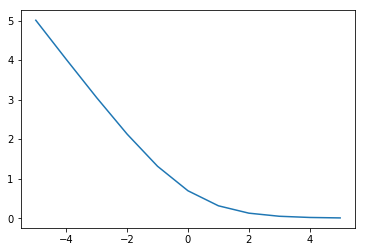

In [147]:
plt.plot(o.asnumpy(), l1.asnumpy())

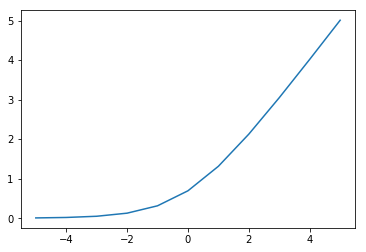

In [148]:
y_2 = y_1 * -1
l2 = loss(y_2, o)
plt.plot(o.asnumpy(),l2.asnumpy())


[-0.9933072  -0.98201376 -0.95257413 -0.8807971  -0.7310586  -1.
 -0.26894143 -0.11920293 -0.04742587 -0.01798621 -0.00669285]
<NDArray 11 @cpu(0)>

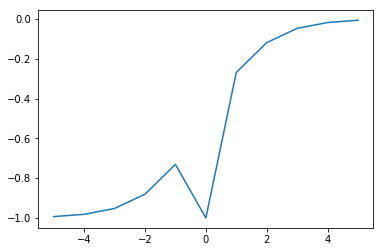

In [149]:
o.attach_grad()
with autograd.record():
    l = loss(y_1, o)
l.backward()
plt.plot(o.asnumpy(),o.grad.asnumpy())
o.grad


[0.00669285 0.01798621 0.04742587 0.11920293 0.26894143 0.
 0.7310586  0.8807971  0.95257413 0.98201376 0.9933072 ]
<NDArray 11 @cpu(0)>

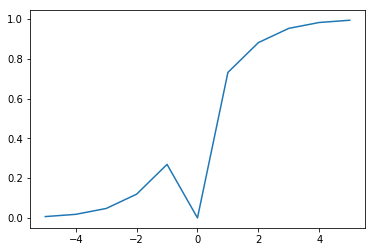

In [150]:
o.attach_grad()
with autograd.record():
    l = loss(y_2, o)
l.backward()
plt.plot(o.asnumpy(),o.grad.asnumpy())
o.grad

# 3. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [54]:
current = nd.array([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = nd.array([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

batch_size = 20
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(current, voltage),
                                   batch_size=batch_size)

def net1(current):
    current2 = current * current
    return current2 * q + current * r + c

def net2(current):
    return current * r + c

def net3(current):
    return current * r

def square_loss(yhat, y):
    return nd.mean((yhat - y) ** 2)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

# 1.
Used 10000 epochs for training with net 1

In [151]:
q = nd.random_normal(shape=(1,1))
r = nd.random_normal(shape=(1, 1))
c = nd.random_normal(shape=1)
params = [q, r, c]

for param in params:
    param.attach_grad()

def net1(current):
    current2 = current * current
    return current2 * q + current * r + c

epochs = 10000
learning_rate = .0005
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net1(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

In [152]:
for param in params:
    print(param)


[[0.37093142]]
<NDArray 1x1 @cpu(0)>

[[37.57215]]
<NDArray 1x1 @cpu(0)>

[11.700154]
<NDArray 1 @cpu(0)>


# 2.
Used 500 epochs for training with net 2

In [153]:
r = nd.random_normal(shape=(1, 1))
c = nd.random_normal(shape=1)
params = [r, c]

for param in params:
    param.attach_grad()
        
epochs = 500
learning_rate = .02
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net2(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

In [154]:
for param in params:
    print(param)


[[41.94047]]
<NDArray 1x1 @cpu(0)>

[0.7294332]
<NDArray 1 @cpu(0)>


# 3.
Used 20 epochs for training with net 3

In [155]:
r = nd.random_normal(shape=(1, 1))
params = [r]

for param in params:
    param.attach_grad()
        
epochs = 20
learning_rate = .02
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net3(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

In [156]:
for param in params:
    print(param)


[[42.056705]]
<NDArray 1x1 @cpu(0)>


# 4. Entropy

Let's compute the *binary* entropy of a number of interesting data sources. 

1. Assume that you're watching the output generated by a [monkey at a typewriter](https://en.wikipedia.org/wiki/File:Chimpanzee_seated_at_typewriter.jpg). The monkey presses any of the $44$ keys of the typewriter at random (you can assume that it has not discovered any special keys or the shift key yet). How many bits of randomness per character do you observe?
1. Unhappy with the monkey you replaced it by a drunk typesetter. It is able to generate words, albeit not coherently. Instead, it picks a random word out of a vocabulary of $2,000$ words. Moreover, assume that the average length of a word is $4.5$ letters in English. How many bits of randomness do you observe now?
1. Still unhappy with the result you replace the typesetter by a high quality language model. These can obtain perplexity numbers as low as 20 points per character. The perplexity is defined as a length normalized probability, i.e.

$$\mathrm{PPL}(x) = \left[p(x)\right]^{1/\mathrm{length}(x)}$$

4.1) log(44) = 5.46 bits/character

4.2) log(2000)/4.5 = 2.44 bits/character

4.3) No question???

# 5. Wien's Approximation for the Temperature (bonus)

We will now abuse Gluon to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

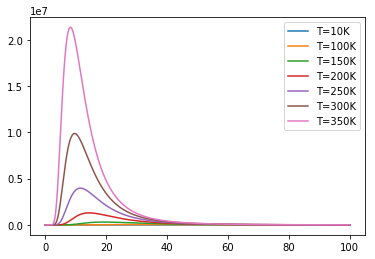

In [4]:
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale) 

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * nd.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = nd.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.asnumpy(), radiance.asnumpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are a fearless physicist measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

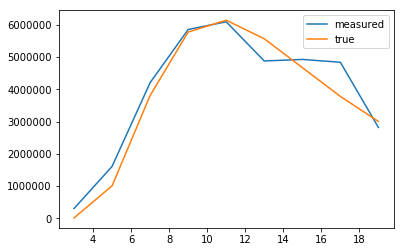

In [5]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = nd.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = nd.random_normal(shape=(len(wavelengths))) * 1

radiance = wien(wavelengths + delta,realtemp)
plt.plot(wavelengths.asnumpy(), radiance.asnumpy(), label='measured')
plt.plot(wavelengths.asnumpy(), wien(wavelengths, realtemp).asnumpy(), label='true')
plt.legend()
plt.show()

Use Gluon to estimate the real temperature based on the variables `wavelengths` and `radiance`. 

* You can use Wien's law implementation `wien(lam,t)` as your forward model. 
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.